<a href="https://colab.research.google.com/github/is-leeroy-jenkins/BudgetPy/blob/master/ipynb/outlays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OMB Reporting

A Machine-Learning Approach to Schedule X
___





Federal budget formulation requires timely estimates for the current execution year (CY), the year of the President’s Budget (BY), and multiple out years (OY). Federal program offices and Agencies must produce horizon-specific forecasts at the account/line level that are internally consistent and defensible. MAX A-11 system is used by OMB and Agencies to enter account structures, transmittal codes, and all the schedules that roll up into the President’s Budget. This analysis uses data from Schedule X.

Resources:
- [Federal Accounts](https://www.usaspending.gov/federal_account)
- [Agency Submissions](https://www.usaspending.gov/submission-statistics?tab=submissions&fy=2025&period=9)
- [Appropriations Law](https://www.kaggle.com/datasets/terryeppler/principles-of-federal-appropriations-law)
- [Circular A-11](https://www.kaggle.com/datasets/terryeppler/omb-circular-a-11)



##### Load Dependencies


In [181]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import (ElasticNet, BayesianRidge, LinearRegression, Ridge, Lasso)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor

In [180]:
hdr = '\r\n' + '-' * 120 + '\r\n'
nwln = '\r\n'
warnings.filterwarnings( 'ignore' )

## 🧩 Descriptive Statistics
___

##### Schedule X Dataset

In [161]:
# 1. Reload the dataset
file_path = r'C:\Users\terry\source\repos\BudgetPy\data\excel\CombinedSchedules.xlsx'
categorical_columns = [ 'MainAccount', 'LineName', 'Line' ]
out_years = [ f'OY-{i}' for i in range( 1, 10 ) ]
numeric_columns = [ 'CombinedSchedulesId', 'PY', 'CY', 'BY' ] + out_years
data_columns = [ 'PY', 'CY', 'BY' ] + [ f'OY-{i}' for i in range( 1, 10 ) ]
all = categorical_columns + numeric_columns

# Read Excel, set index and load columns
df_excel = pd.read_excel( file_path, usecols = all, sheet_name = 'Data' )
sns.set_style( "darkgrid" )

# Define complete dataset
df_dataset = df_excel[ all ]
df_dataset.set_index( 'CombinedSchedulesId' , inplace = True )

# 2. Display the first few rows
print( hdr )
print( 'Dataset' )
print( nwln )
df_dataset.head( )


------------------------------------------------------------------------------------------------------------------------

Dataset




,MainAccount,LineName,Line,PY,CY,BY,OY-1,OY-2,OY-3,OY-4,OY-5,OY-6,OY-7,OY-8,OY-9
CombinedSchedulesId,,,,,,,,,,,,,,,
1,A-0103,TACKLE THE CLIMATE CRISIS,L-0001,901000000,901000000,901000000,0,0,0,0,0,0,0,0,0
2,A-0103,TAKE DECISIVE ACTION TO ADVANCE ENVIRONMENTAL ...,L-0002,82000000,82000000,82000000,0,0,0,0,0,0,0,0,0
3,A-0103,ENFORCE ENVIRONMENTAL LAWS,L-0003,29000000,29000000,29000000,0,0,0,0,0,0,0,0,0
4,A-0103,ENSURE CLEAN AND HEALTHY AIR,L-0011,348000000,348000000,348000000,0,0,0,0,0,0,0,0,0
5,A-0103,ENSURE CLEAN AND SAFE WATER,L-0012,10508000000,12508000000,10508000000,0,0,0,0,0,0,0,0,0


##### Subset

In [5]:
# Define datasets
df_numeric = df_excel[ all ].copy( )
df_numeric.set_index( 'CombinedSchedulesId', inplace = True )
df_numeric = df_numeric[ data_columns ].astype( float )

df_categorical = df_excel[ all ].copy( )
df_categorical.set_index( 'CombinedSchedulesId', inplace = True )
df_categorical = df_categorical[ categorical_columns ].astype( str )

df_data = df_excel[ all ].copy( )
df_data[ numeric_columns ] = df_data[ numeric_columns ].astype( float )
df_data[ 'CombinedSchedulesId' ] = df_data[ 'CombinedSchedulesId' ].astype( int )
df_data = df_data.set_index( 'CombinedSchedulesId' )

# 2. Display the first few rows
print( hdr )
print( 'Outlays Subset' )
print( nwln )
df_data.head( )


------------------------------------------------------------------------------------------------------------------------

Outlays Subset




,MainAccount,LineName,Line,PY,CY,BY,OY-1,OY-2,OY-3,OY-4,OY-5,OY-6,OY-7,OY-8,OY-9
CombinedSchedulesId,,,,,,,,,,,,,,,
1,A-0103,TACKLE THE CLIMATE CRISIS,L-0001,9.010000e+08,9.010000e+08,9.010000e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A-0103,TAKE DECISIVE ACTION TO ADVANCE ENVIRONMENTAL ...,L-0002,8.200000e+07,8.200000e+07,8.200000e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A-0103,ENFORCE ENVIRONMENTAL LAWS,L-0003,2.900000e+07,2.900000e+07,2.900000e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A-0103,ENSURE CLEAN AND HEALTHY AIR,L-0011,3.480000e+08,3.480000e+08,3.480000e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,A-0103,ENSURE CLEAN AND SAFE WATER,L-0012,1.050800e+10,1.250800e+10,1.050800e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 3. Display column names
print( hdr )
print( 'Outlays Schema' )
print( nwln )

df_dataset.columns

In [7]:
# 3. Display Outlays Descriptive Statistics
print( hdr )
print( 'Dataset Descriptive Statistics' )
print( nwln )

df_dataset.describe()


------------------------------------------------------------------------------------------------------------------------

Dataset Descriptive Statistics




,CombinedSchedulesId,PY,CY,BY,OY-1,OY-2,OY-3,OY-4,OY-5,OY-6,OY-7,OY-8,OY-9
count,2400.000000,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03
mean,1200.500000,6.156629e+08,6.235775e+08,6.192235e+09,8.378417e+07,8.669083e+07,9.226792e+07,9.946292e+07,4.720750e+07,4.741958e+07,4.686333e+07,4.748917e+07,4.742958e+07
std,692.964646,3.507293e+09,3.584782e+09,1.430772e+11,8.903553e+08,1.079273e+09,1.295100e+09,1.534985e+09,4.735221e+08,4.743833e+08,4.787383e+08,4.845735e+08,4.872255e+08
min,1.000000,-7.069000e+09,-3.342300e+10,-1.257400e+10,-5.520000e+08,-5.650000e+08,-5.780000e+08,-5.910000e+08,-6.050000e+08,-6.190000e+08,-6.330000e+08,-6.480000e+08,-6.630000e+08
25%,600.750000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1200.500000,1.000000e+06,1.000000e+06,1.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1800.250000,5.000000e+07,4.500000e+07,4.425000e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2400.000000,6.292300e+10,6.446400e+10,4.528039e+12,2.585500e+10,3.509500e+10,4.490200e+10,5.382000e+10,1.252500e+10,1.277500e+10,1.303100e+10,1.329100e+10,1.355700e+10


In [8]:
# 3. Display Subset Descriptive Statistics
print( hdr )
print( 'Subset Descriptive Statistics' )
print( nwln )

df_data.describe()


------------------------------------------------------------------------------------------------------------------------

Subset Descriptive Statistics




,PY,CY,BY,OY-1,OY-2,OY-3,OY-4,OY-5,OY-6,OY-7,OY-8,OY-9
count,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03
mean,6.156629e+08,6.235775e+08,6.192235e+09,8.378417e+07,8.669083e+07,9.226792e+07,9.946292e+07,4.720750e+07,4.741958e+07,4.686333e+07,4.748917e+07,4.742958e+07
std,3.507293e+09,3.584782e+09,1.430772e+11,8.903553e+08,1.079273e+09,1.295100e+09,1.534985e+09,4.735221e+08,4.743833e+08,4.787383e+08,4.845735e+08,4.872255e+08
min,-7.069000e+09,-3.342300e+10,-1.257400e+10,-5.520000e+08,-5.650000e+08,-5.780000e+08,-5.910000e+08,-6.050000e+08,-6.190000e+08,-6.330000e+08,-6.480000e+08,-6.630000e+08
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+06,1.000000e+06,1.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e+07,4.500000e+07,4.425000e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.292300e+10,6.446400e+10,4.528039e+12,2.585500e+10,3.509500e+10,4.490200e+10,5.382000e+10,1.252500e+10,1.277500e+10,1.303100e+10,1.329100e+10,1.355700e+10


#### Descriptive Statistics
- Summarizes numerical and categorical data in a concise and informative manner.
- Uses metrics such as measures of center, variability, shape, and location, to describe key features of the data.

In [167]:

descriptive_stats = {
    "Mean": df_numeric.mean( ).round( 2 ),
    "Median": df_numeric.median( ).round( 2 ),
    "Mode": df_numeric.mode( ).iloc[ 0 ].round( 2 ),
    "Standard Deviation": df_numeric.std( ).round( 2 ),
    "Variance": df_numeric.var( ).round(2 ),
    "Q1 (25%)": df_numeric.quantile( 0.25 ).round( 2 ),
    "Q3 (75%)": df_numeric.quantile( 0.75 ).round( 2 ),
    "IQR": ( df_numeric.quantile( 0.75 ) - df_numeric.quantile( 0.25 )),
}

print( hdr )
print('I. Descriptive Data')
print( nwln )

df_descriptive = pd.DataFrame( descriptive_stats )
df_descriptive


------------------------------------------------------------------------------------------------------------------------

I. Descriptive Data




,Mean,Median,Mode,Standard Deviation,Variance,Q1 (25%),Q3 (75%),IQR
PY,1.017625e+09,7.630000e+08,1.017625e+09,3.471820e+09,1.205353e+19,1.400000e+07,1.017625e+09,1.003625e+09
CY,1.098815e+09,1.098815e+09,1.098815e+09,3.543189e+09,1.255419e+19,2.100000e+07,1.098815e+09,1.077815e+09
BY,1.069933e+10,1.040000e+09,1.069933e+10,1.429796e+11,2.044317e+22,2.000000e+07,1.069933e+10,1.067933e+10
OY-1,4.163188e+08,4.163188e+08,4.163188e+08,8.745627e+08,7.648599e+17,4.163188e+08,4.163188e+08,0.000000e+00
OY-2,4.455203e+08,4.455203e+08,4.455203e+08,1.064759e+09,1.133711e+18,4.455203e+08,4.455203e+08,0.000000e+00
OY-3,4.965090e+08,4.965090e+08,4.965090e+08,1.280613e+09,1.639969e+18,4.965090e+08,4.965090e+08,0.000000e+00
OY-4,5.462494e+08,5.462494e+08,5.462494e+08,1.520435e+09,2.311722e+18,5.462494e+08,5.462494e+08,0.000000e+00
OY-5,2.647150e+08,2.647150e+08,2.647150e+08,4.625483e+08,2.139509e+17,2.647150e+08,2.647150e+08,0.000000e+00
OY-6,2.709690e+08,2.709690e+08,2.709690e+08,4.630707e+08,2.144345e+17,2.709690e+08,2.709690e+08,0.000000e+00
OY-7,2.797811e+08,2.797811e+08,2.797811e+08,4.671943e+08,2.182705e+17,2.797811e+08,2.797811e+08,0.000000e+00



------------------------------------------------------------------------------------------------------------------------

Histogram




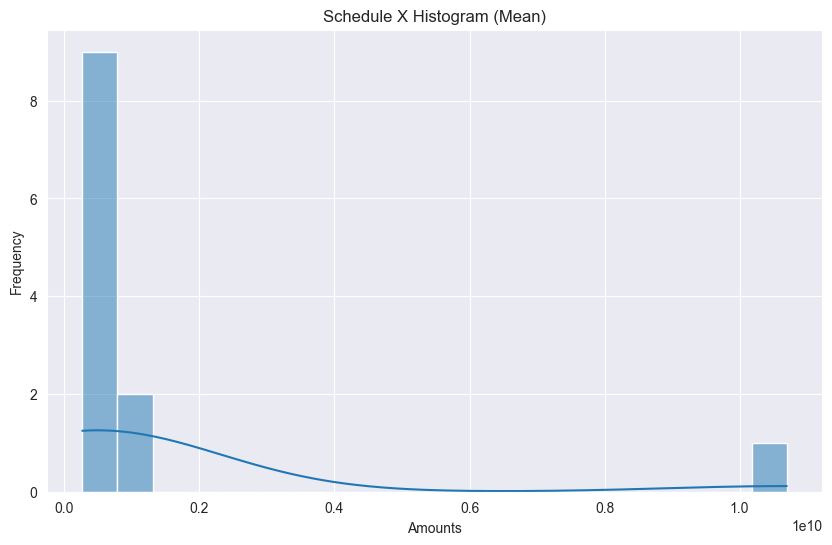

In [168]:
print( hdr )
print( 'Histogram' )
print( nwln )

plt.figure(figsize=(10, 6))
sns.histplot(df_numeric.mean( ), bins=20, kde=True )
plt.title('Schedule X Histogram (Mean)')
plt.xlabel('Amounts')
plt.ylabel('Frequency')
plt.show()



#### Probability Distributions
- A statistical function that describes all the possible values and likelihoods that a random variable can take within a given range.


------------------------------------------------------------------------------------------------------------------------

II. Probabilty Distribution Graph




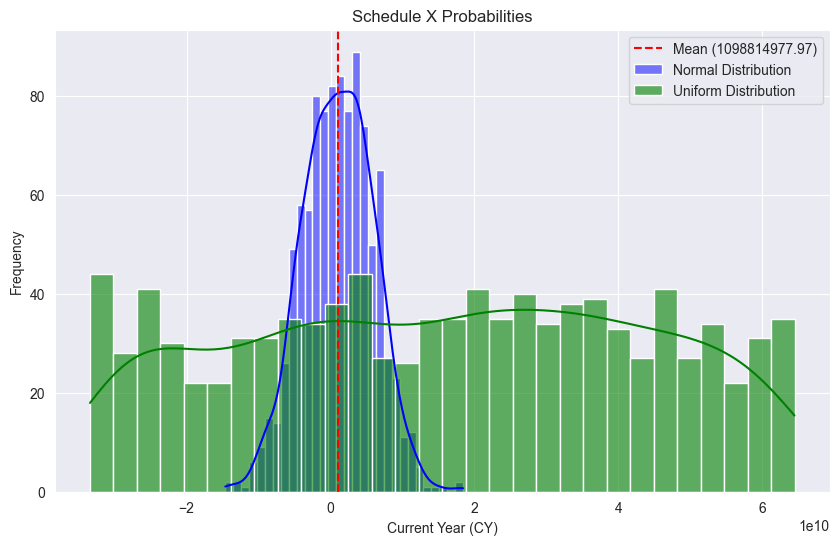

In [169]:
# 1. Selecting FY2024 data and removing zeros for statistical analysis
df_currentyear = df_data[ 'CY' ].replace( 0, np.nan ).dropna( )

# 2. Generating Normal Distribution
mu, sigma = np.mean( df_currentyear ), np.std( df_currentyear )
normal_dist = np.random.normal(mu, sigma, 1000 )

# 3. Generating Uniform Distribution
uniform_dist = np.random.uniform( df_currentyear.min( ), df_currentyear.max( ), 1000 )

print( hdr )
print( 'II. Probabilty Distribution Graph')
print( nwln )

# 4. Plotting the Distributions
plt.figure( figsize=( 10, 6 ) )
sns.histplot( normal_dist, bins=30, kde=True, color='blue', label='Normal Distribution')
sns.histplot( uniform_dist, bins=30, kde=True, color='green', label='Uniform Distribution', alpha=0.6)
plt.axvline( mu, color='red', linestyle='dashed', label=f'Mean ({mu:.2f})')
plt.legend( )
plt.title( 'Schedule X Probabilities' )
plt.xlabel( 'Current Year (CY)' )
plt.ylabel( 'Frequency' )
plt.show( )


#### Inferential Statistics

- Involves the use of a sample (1) to estimate some characteristic in a large population; and (2) to test a research hypothesis about a given population.
- To appropriately estimate a population characteristic, or parameter, a random and unbiased sample must be drawn from the population of interest

In [171]:
# Perform a One-Sample t-Test to check if the mean of FY2024 outlays significantly differs from zero
t_stat, p_value = stats.ttest_1samp(df_currentyear, 0 )

# Perform an ANOVA test across multiple fiscal years (CY to BY)
df_anova = df_numeric.loc[ :, 'CY':'BY' ]
anova_stat, anova_p = stats.f_oneway(*[df_anova[col] for col in df_anova.columns])

# Display results in a DataFrame
df_hypothesis = pd.DataFrame({
    "Test": ["One-Sample t-Test", 'ANOVA'],
    "Statistic": [t_stat, anova_stat],
    "p-Value": [p_value, anova_p]
}).round(4)

print( hdr )
print( 'III. Inferential Analysis')
print( nwln )

df_summary = pd.DataFrame(df_hypothesis)
df_summary


------------------------------------------------------------------------------------------------------------------------

III. Inferential Analysis




,Test,Statistic,p-Value
0,One-Sample t-Test,8.6205,0.000
1,ANOVA,10.8140,0.001


## 🛠️  Feature Engineering
___

##### Dimensionality Reduction

In [172]:
print( hdr )
print( 'Numeric Data')
print( nwln )

df_numeric


------------------------------------------------------------------------------------------------------------------------

Numeric Data




,PY,CY,BY,OY-1,OY-2,OY-3,OY-4,OY-5,OY-6,OY-7,OY-8,OY-9
CombinedSchedulesId,,,,,,,,,,,,
1,9.010000e+08,9.010000e+08,9.010000e+08,4.163188e+08,4.455203e+08,4.965090e+08,5.462494e+08,2.647150e+08,2.709690e+08,2.797811e+08,2.929923e+08,3.043610e+08
2,8.200000e+07,8.200000e+07,8.200000e+07,4.163188e+08,4.455203e+08,4.965090e+08,5.462494e+08,2.647150e+08,2.709690e+08,2.797811e+08,2.929923e+08,3.043610e+08
3,2.900000e+07,2.900000e+07,2.900000e+07,4.163188e+08,4.455203e+08,4.965090e+08,5.462494e+08,2.647150e+08,2.709690e+08,2.797811e+08,2.929923e+08,3.043610e+08
4,3.480000e+08,3.480000e+08,3.480000e+08,4.163188e+08,4.455203e+08,4.965090e+08,5.462494e+08,2.647150e+08,2.709690e+08,2.797811e+08,2.929923e+08,3.043610e+08
5,1.050800e+10,1.250800e+10,1.050800e+10,4.163188e+08,4.455203e+08,4.965090e+08,5.462494e+08,2.647150e+08,2.709690e+08,2.797811e+08,2.929923e+08,3.043610e+08
...,...,...,...,...,...,...,...,...,...,...,...,...
2396,1.000000e+06,1.000000e+06,1.000000e+06,4.163188e+08,4.455203e+08,4.965090e+08,5.462494e+08,2.647150e+08,2.709690e+08,2.797811e+08,2.929923e+08,3.043610e+08
2397,1.000000e+06,1.000000e+06,1.000000e+06,4.163188e+08,4.455203e+08,4.965090e+08,5.462494e+08,2.647150e+08,2.709690e+08,2.797811e+08,2.929923e+08,3.043610e+08
2398,2.000000e+07,2.000000e+07,2.600000e+07,4.163188e+08,4.455203e+08,4.965090e+08,5.462494e+08,2.647150e+08,2.709690e+08,2.797811e+08,2.929923e+08,3.043610e+08


#### Normalization ( Z-score Scaling )
- A method of standardizing data by representing each value as the number of standard deviations it is from the mean.

In [173]:
scaler = MinMaxScaler( )
df_normalized = pd.DataFrame( scaler.fit_transform( df_numeric ), columns=df_numeric.columns )

print( hdr )
print( 'Normalized Outlay Data' )
print( nwln )

df_normalized.round( 4 )


------------------------------------------------------------------------------------------------------------------------

Normalized Outlay Data




,PY,CY,BY,OY-1,OY-2,OY-3,OY-4,OY-5,OY-6,OY-7,OY-8,OY-9
0,0.1139,0.3506,0.0030,0.0367,0.0283,0.0236,0.0209,0.0662,0.0664,0.0668,0.0675,0.068
1,0.1022,0.3423,0.0028,0.0367,0.0283,0.0236,0.0209,0.0662,0.0664,0.0668,0.0675,0.068
2,0.1014,0.3417,0.0028,0.0367,0.0283,0.0236,0.0209,0.0662,0.0664,0.0668,0.0675,0.068
3,0.1060,0.3450,0.0028,0.0367,0.0283,0.0236,0.0209,0.0662,0.0664,0.0668,0.0675,0.068
4,0.2511,0.4692,0.0051,0.0367,0.0283,0.0236,0.0209,0.0662,0.0664,0.0668,0.0675,0.068
...,...,...,...,...,...,...,...,...,...,...,...,...
2395,0.1010,0.3415,0.0028,0.0367,0.0283,0.0236,0.0209,0.0662,0.0664,0.0668,0.0675,0.068
2396,0.1010,0.3415,0.0028,0.0367,0.0283,0.0236,0.0209,0.0662,0.0664,0.0668,0.0675,0.068
2397,0.1013,0.3416,0.0028,0.0367,0.0283,0.0236,0.0209,0.0662,0.0664,0.0668,0.0675,0.068
2398,0.1013,0.3416,0.0028,0.0367,0.0283,0.0236,0.0209,0.0662,0.0664,0.0668,0.0675,0.068


#### Standardization ( Max-Min Scaling )
- Rescaling the range of features to scale the range in [0, 1] or [−1, 1]

In [16]:
standardizer = StandardScaler( )
df_standardized = pd.DataFrame( standardizer.fit_transform( df_numeric ), columns=df_numeric.columns )
print( hdr )
print( 'Standardized Outlay Data')
print( nwln )

df_standardized.round( 4 )


------------------------------------------------------------------------------------------------------------------------

VI. Standardized Outlay Data




,PY,CY,BY,OY-1,OY-2,OY-3,OY-4,OY-5,OY-6,OY-7,OY-8,OY-9
0,0.0814,0.0774,-0.0370,-0.0941,-0.0803,-0.0713,-0.0648,-0.0997,-0.1,-0.0979,-0.098,-0.0974
1,-0.1522,-0.1511,-0.0427,-0.0941,-0.0803,-0.0713,-0.0648,-0.0997,-0.1,-0.0979,-0.098,-0.0974
2,-0.1673,-0.1659,-0.0431,-0.0941,-0.0803,-0.0713,-0.0648,-0.0997,-0.1,-0.0979,-0.098,-0.0974
3,-0.0763,-0.0769,-0.0409,-0.0941,-0.0803,-0.0713,-0.0648,-0.0997,-0.1,-0.0979,-0.098,-0.0974
4,2.8211,3.3159,0.0302,-0.0941,-0.0803,-0.0713,-0.0648,-0.0997,-0.1,-0.0979,-0.098,-0.0974
...,...,...,...,...,...,...,...,...,...,...,...,...
2395,-0.1753,-0.1737,-0.0433,-0.0941,-0.0803,-0.0713,-0.0648,-0.0997,-0.1,-0.0979,-0.098,-0.0974
2396,-0.1753,-0.1737,-0.0433,-0.0941,-0.0803,-0.0713,-0.0648,-0.0997,-0.1,-0.0979,-0.098,-0.0974
2397,-0.1699,-0.1684,-0.0431,-0.0941,-0.0803,-0.0713,-0.0648,-0.0997,-0.1,-0.0979,-0.098,-0.0974
2398,-0.1704,-0.1690,-0.0431,-0.0941,-0.0803,-0.0713,-0.0648,-0.0997,-0.1,-0.0979,-0.098,-0.0974


#### Pricipal Component Analysis (PCA)
- A linear dimensionality reduction technique with applications in exploratory data analysis, visualization and data preprocessing.
- The data is linearly transformed onto a new coordinate system such that the directions capturing the largest variation in the data can be easily identified

In [174]:
pca = PCA( n_components=2 )
pca_result = pca.fit_transform( df_numeric )
df_pca = pd.DataFrame( pca_result, columns=[ 'Component-1', 'Component-2' ])


print( hdr )
print( 'Prinicipal Compnent Analysis' )
print( nwln )

df_pca


------------------------------------------------------------------------------------------------------------------------

Prinicipal Compnent Analysis




,Component-1,Component-2
0,-9.798446e+09,-2.175558e+08
1,-1.061807e+10,-1.373618e+09
2,-1.067111e+10,-1.448430e+09
3,-1.035187e+10,-9.981446e+08
4,-1.833092e+08,1.477662e+10
...,...,...
2395,-1.069913e+10,-1.487953e+09
2396,-1.069913e+10,-1.487953e+09
2397,-1.067412e+10,-1.461137e+09
2398,-1.067512e+10,-1.463961e+09


#### K-Means Clustering
- A machinel learning method for grouping data into clusters based on similarity

In [175]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_clusters = kmeans.fit_predict(df_standardized)

kmeans_clusters

array([0, 0, 0, ..., 0, 0, 0])

#### PCA + K-Means
- Combines and applies K-Means Clustering with Pricipal Component Analysis


------------------------------------------------------------------------------------------------------------------------

IX. PCA & k-Means




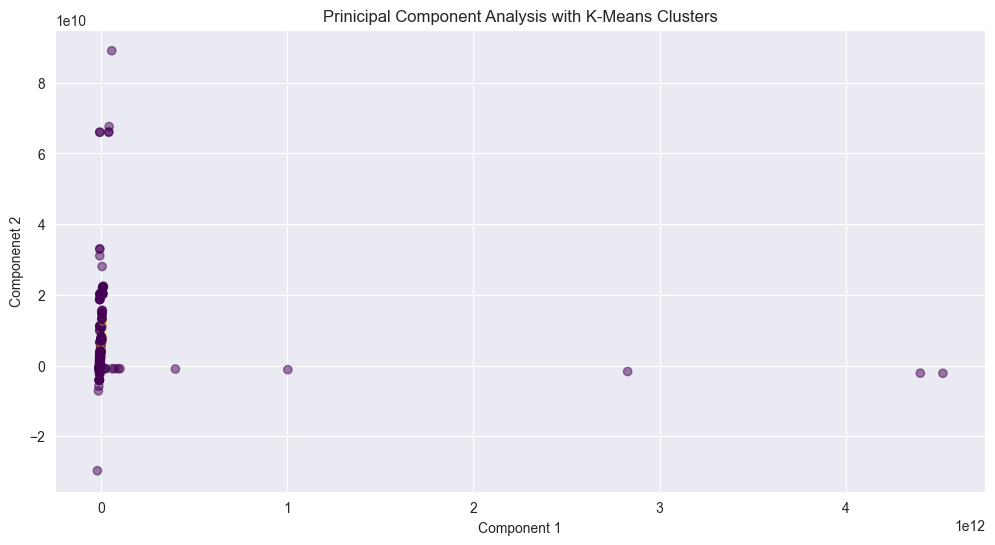


------------------------------------------------------------------------------------------------------------------------

Comparison of Primary Components




,Component-1,Component-2
0,-5.291121e+09,3.893587e+08
1,-6.110456e+09,-7.671927e+08
2,-6.163478e+09,-8.420367e+08
3,-5.844347e+09,-3.915607e+08
4,4.320274e+09,1.539096e+10
...,...,...
2395,-6.191489e+09,-8.815769e+08
2396,-6.191489e+09,-8.815769e+08
2397,-6.166481e+09,-8.547478e+08
2398,-6.167482e+09,-8.575724e+08


In [119]:
print( hdr )
print( 'PCA & k-Means')
print( nwln )

plt.figure(figsize=(12, 6))
plt.scatter(df_pca['Component-1'], df_pca['Component-2'],  c=kmeans_clusters, cmap='viridis', alpha=0.5)
plt.title("Prinicipal Component Analysis with K-Means Clusters")
plt.xlabel("Component 1")
plt.ylabel("Componenet 2")
plt.show()

print( hdr )
print( 'Comparison of Primary Components')
print( nwln )

df_pca

### Observations:

##### PCA Results:
- The first two principal components explain the majority of the variance in budget outlays, helping to simplify complex data.

##### K-means Clustering:
- The data naturally clusters into three groups, potentially reflecting different spending patterns across agencies or time periods.


## 📊  Correlation Analysis
___

#### Pearson Correlation
- A correlation that measures the linear relationship between two sets of data


------------------------------------------------------------------------------------------------------------------------

Pearson Correlation Heatmap




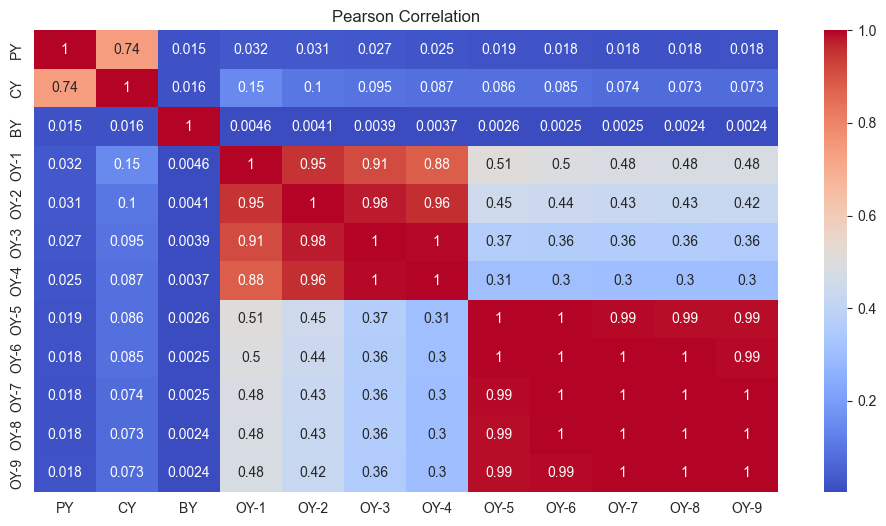

In [120]:
pearson_corr = df_numeric.corr(method= 'pearson' )
print( hdr )
print( 'Pearson Correlation Heatmap')
print( nwln )

# Plot heatmaps of different correlations
plt.figure(figsize=(12, 6))
sns.heatmap( pearson_corr, cmap="coolwarm", annot=True )
plt.title('Pearson Correlation')
plt.show( )

#### Spearman Correlation
-  A statistical technique used to determine if two variables are related.
- It's used when the relationship between the variables is not linear, or when the data is not normally distributed.

In [176]:
spearman_corr = df_numeric.corr(method= 'spearman' )


------------------------------------------------------------------------------------------------------------------------

Spearman Correlation




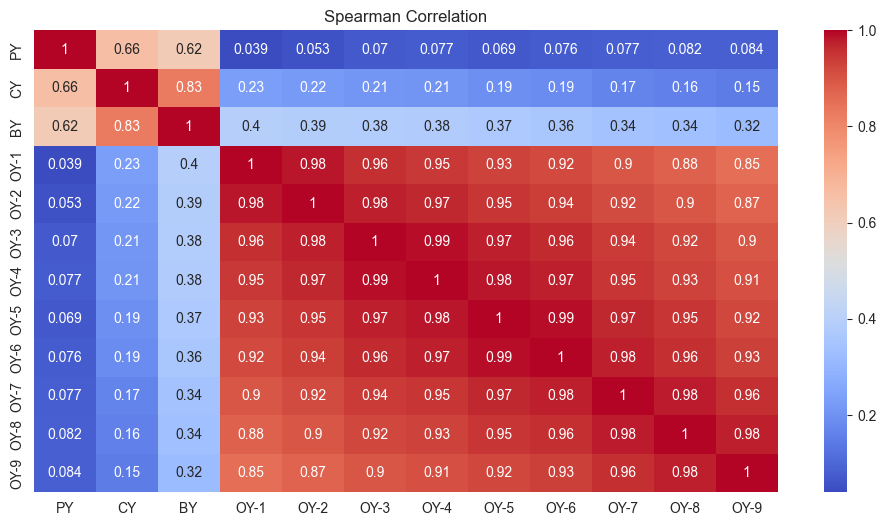

In [106]:
print( hdr )
print( 'Spearman Correlation')
print( nwln )

plt.figure(figsize=(12, 6))
sns.heatmap(spearman_corr, cmap='coolwarm', annot=True)
plt.title('Spearman Correlation')
plt.show()


#### Kendall Correlation
- A non-parametric statistical test that measures the association between two variables.
- It's used to determine if there is a correlation between two sets of ranks



In [30]:
kendall_corr = df_numeric.corr(method= 'kendall' )


------------------------------------------------------------------------------------------------------------------------

XIII. Tau Correlation




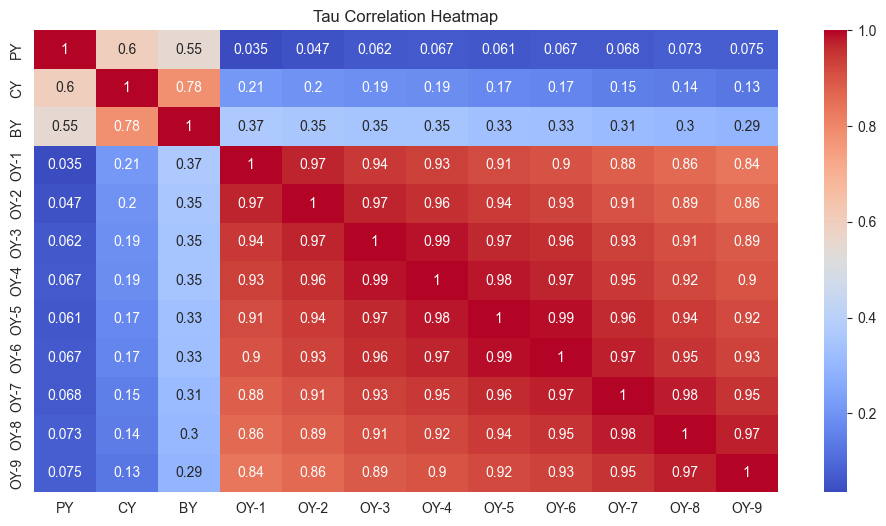

In [31]:
print( hdr )
print( 'XIII. Tau Correlation')
print( nwln )

plt.figure(figsize=(12, 6))
sns.heatmap(kendall_corr, cmap="coolwarm", annot=True)
plt.title("Tau Correlation Heatmap")
plt.show()


In [32]:
# Prepare dataframe for correlation comparison
df_correlation = pd.DataFrame({ 'Pearson Correlation': pearson_corr.iloc[:-1, -1].values,
    "Spearman Correlation": spearman_corr.iloc[:-1, -1].values,
    "Kendall Correlation": kendall_corr.iloc[:-1, -1].values,
})

# Display correlation comparison results
print( hdr )
print( 'XIV.  Table of Correlations')
print( nwln )
df_correlation


------------------------------------------------------------------------------------------------------------------------

XIV.  Table of Correlations




,Pearson Correlation,Spearman Correlation,Kendall Correlation
0,-0.000324,0.084285,0.074704
1,0.058041,0.145578,0.131781
2,-0.001557,0.319683,0.291364
3,0.478117,0.852930,0.837785
4,0.424597,0.873899,0.862148
5,0.356553,0.898193,0.889753
6,0.301387,0.907829,0.900852
7,0.989528,0.924797,0.918717
8,0.995055,0.933602,0.928508
9,0.998391,0.956119,0.952796


## 📈  Regression Modeling
- Methods to determine the strength and character of the relationship between a dependent variable and one or more independent variables
___

In [121]:
# Define future target years: Current Year and Budget Year
target_years = [ 'CY', 'BY', 'OY-1', 'OY-2' ]

# Extend dataset for forecasting
df_numeric = df_numeric.copy( )

# Use all Out Years as predictors
X_numeric = df_numeric.iloc[ :, :-4 ]

# Predict Outyear 1
y_numeric = df_numeric.iloc[ :, -4: ]

# Standardize features
scaler = StandardScaler()
X_standardized = scaler.fit_transform( X_numeric )

# Initialize regression models
regression_models = {
    'Linear Regression': LinearRegression( ),
    'Ridge Regression': Ridge( alpha=10.0, max_iter=10000 ),
    'Lasso Regression': Lasso( alpha=10.0, max_iter=10000 ),
    'ElasticNet Regression': ElasticNet( alpha=0.1, l1_ratio=0.5 ),
    'Bayesian Ridge Regression': BayesianRidge( max_iter=10000 ),
    'Random Forest Regression': RandomForestRegressor( n_estimators=50, random_state=42 ),
    'Gradient Boosting Regression': GradientBoostingRegressor( n_estimators=50, random_state=42 ),
    'Polynomial Regression (Degree=2)': LinearRegression( ),
}

# Polynomial transformation for polynomial regression
poly = PolynomialFeatures( degree=2 )
X_polynomial = poly.fit_transform( X_standardized )

# Fit and evaluate models for the outyears
regression_scores = { year: {} for year in target_years }

# Select target year
for year_idx, year in enumerate( target_years ):
    y_future = y_numeric.iloc[ :, year_idx ]

    for name, model in regression_models.items( ):
        if "Polynomial" in name:
            model.fit( X_polynomial, y_future )
            score_future = model.score( X_polynomial, y_future )
        else:
            model.fit( X_standardized, y_future )
            score_future = model.score( X_standardized, y_future )
        regression_scores[ year ][ name ] = round( score_future, 2 )

# Create ranked results for each year
df_results = {}
for year in target_years:
    ranked_models_future = sorted(regression_scores[year ].items( ), key=lambda x: x[1 ], reverse=True )
    df_results[year] = pd.DataFrame(ranked_models_future, columns=[ "Regression Model", f"R² Score ({year})" ] )

# Prepare data for visualization
forecast_years = [ 'CY','BY','OY-1', 'OY-2' ]
model_names = list( regression_models.keys( ) )

print(hdr)
print('Out Year 2')
print( nwln )
df_results[ 'OY-2' ]


------------------------------------------------------------------------------------------------------------------------

Out Year 2




,Regression Model,R² Score (OY-2)
0,Gradient Boosting Regression,1.00
1,Linear Regression,0.99
2,Ridge Regression,0.99
3,Lasso Regression,0.99
4,Random Forest Regression,0.99
5,Polynomial Regression (Degree=2),0.99
6,ElasticNet Regression,0.98
7,Bayesian Ridge Regression,0.00


In [162]:
print(hdr)
print('Outyear 1')
print( nwln )

df_results[ 'OY-1' ]


------------------------------------------------------------------------------------------------------------------------

Outyear 1




,Regression Model,R² Score (OY-1)
0,Gradient Boosting Regression,1.00
1,Polynomial Regression (Degree=2),1.00
2,Linear Regression,0.99
3,Ridge Regression,0.99
4,Lasso Regression,0.99
5,Random Forest Regression,0.99
6,ElasticNet Regression,0.98
7,Bayesian Ridge Regression,0.00


In [109]:
print(hdr)
print('Current Year')
print( nwln )

df_results[ "CY" ]


------------------------------------------------------------------------------------------------------------------------

Current Year




,Regression Model,R² Score (CY)
0,Linear Regression,1.00
1,Ridge Regression,1.00
2,Lasso Regression,1.00
3,Gradient Boosting Regression,1.00
4,Polynomial Regression (Degree=2),1.00
5,ElasticNet Regression,0.99
6,Random Forest Regression,0.99
7,Bayesian Ridge Regression,0.00


In [163]:
print(hdr)
print('Budget Year')
print( nwln )

df_results[ "BY" ]


------------------------------------------------------------------------------------------------------------------------

Budget Year




,Regression Model,R² Score (BY)
0,Gradient Boosting Regression,1.00
1,Polynomial Regression (Degree=2),1.00
2,Linear Regression,0.99
3,Ridge Regression,0.99
4,Lasso Regression,0.99
5,ElasticNet Regression,0.99
6,Random Forest Regression,0.99
7,Bayesian Ridge Regression,0.00


#### 📊 K-Nearest Neighbors Regression:
- This scatterplot compares actual values to the predicted values using a KNN regressor.
- The model makes predictions by averaging the outputs of the 5 nearest data points in feature space.


------------------------------------------------------------------------------------------------------------------------

k-NN Regression Performance


Training Score: 65.0%
Testing  Score:  83.4%




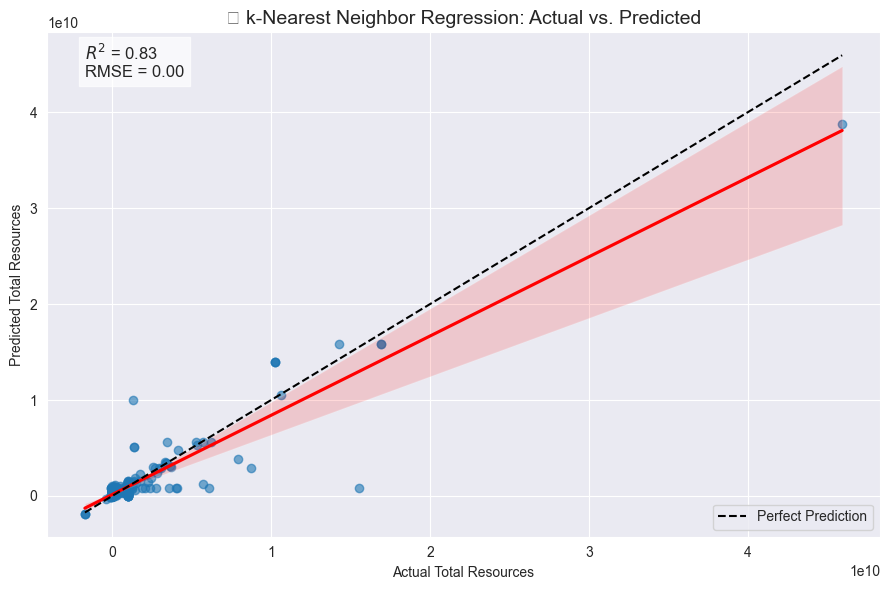

In [177]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( 'Not enough numeric columns for modeling.' )

# Prepare values for regression and classification
values = df_numeric.iloc[ :, 1: ]
target = df_numeric.iloc[ :, 0 ]
classifier = (target > target.median( )).astype( int )

# Standardize features
scaler = StandardScaler( )
data = scaler.fit_transform( values )

# Split values
X_training, X_testing, y_training, y_testing = train_test_split( data, target, random_state = 42 )

# Train, fit & predict
knn_reg = KNeighborsRegressor( n_neighbors = 5 )
knn_reg.fit( X_training, y_training )
y_pred_knn_reg = knn_reg.predict( X_testing )
print( hdr )
print( 'k-NN Regression Performance' )
print( nwln )

# Score Model
training_score = f'Training Score: {knn_reg.score( X_training, y_training ):.1%}'
testing_score = f'Testing  Score:  {knn_reg.score( X_testing, y_testing ):.1%}'
print( training_score )
print( testing_score )
print( nwln )

# === Regression Plot ===
r2 = r2_score( y_testing, y_pred_knn_reg )
rmse = mean_squared_error( y_testing, y_pred_knn_reg )
if rmse > 100000000:
	rmse = 0.0
plt.figure( figsize = (9, 6) )
sns.regplot( x = y_testing, y = y_pred_knn_reg, scatter_kws = { 'alpha': 0.6 },
	line_kws = { 'color': 'red' } )
plt.plot( [ y_testing.min( ), y_testing.max( ) ], [ y_testing.min( ), y_testing.max( ) ], 'k--',
	label = 'Perfect Prediction' )
plt.text( x = y_testing.min( ), y = y_testing.max( ) * 0.95,
	s = f'$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}',
	fontsize = 12, bbox = dict( facecolor = 'white', alpha = 0.7 ) )
plt.xlabel( 'Actual Total Resources' )
plt.ylabel( 'Predicted Total Resources' )
plt.title( '🌳 k-Nearest Neighbor Regression: Actual vs. Predicted', fontsize = 14 )
plt.legend( )
plt.grid( True )
plt.tight_layout( )
plt.show( )

#### 🌳 Decision Tree Regression:
- This plot displays the predictions of a decision tree regression model trained on federal account-level financial data using TotalResources as the target.
- The tree partitions feature space into axis-aligned regions to minimize error in predicting continuous values.
- The vertical scatter seen in the plot reflects the model's nonlinear, piecewise-constant approximation behavior.
- It's interpretable and fast but may overfit if not pruned or tuned.


------------------------------------------------------------------------------------------------------------------------

Model Performance


Training Score: 68.8%
Testing  Score:  82.9%




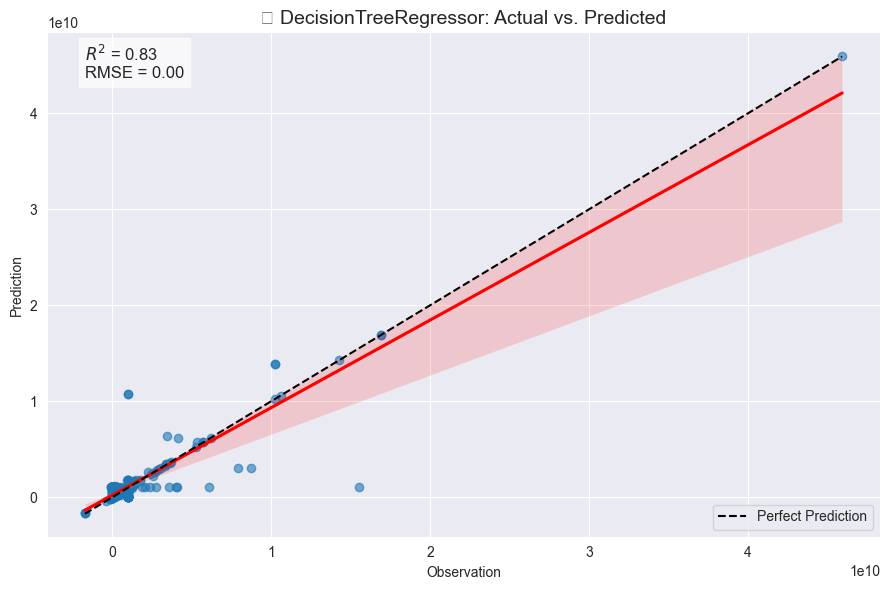

In [178]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( 'Not enough numeric columns for modeling.' )

# Prepare values for regression and classification
values = df_numeric.iloc[ :, 1: ]
target = df_numeric.iloc[ :, 0 ]
classifier = (target > target.median( )).astype( int )

# Standardize features
scaler = StandardScaler( )
data = scaler.fit_transform( values )

# Split values
X_training, X_testing, y_training, y_testing = train_test_split( data, target, random_state = 42 )

# Regression
dt_reg = DecisionTreeRegressor( random_state = 42 )
dt_reg.fit( X_training, y_training )
y_pred_reg = dt_reg.predict( X_testing )
print( hdr )
print( 'Model Performance' )
print( nwln )

# Score Model
training_score = f'Training Score: {dt_reg.score( X_training, y_training ):.1%}'
testing_score = f'Testing  Score:  {dt_reg.score( X_testing, y_testing ):.1%}'
print( training_score )
print( testing_score )
print( nwln )

# === Regression Plot ===
r2 = r2_score( y_testing, y_pred_reg )
rmse = mean_squared_error( y_testing, y_pred_reg )
if rmse > 100000000:
	rmse = 0.0
plt.figure( figsize = (9, 6) )
sns.regplot( x = y_testing, y = y_pred_reg, scatter_kws = { 'alpha': 0.6 },
	line_kws = { 'color': 'red' } )
plt.plot( [ y_testing.min( ), y_testing.max( ) ], [ y_testing.min( ), y_testing.max( ) ], 'k--',
	label = 'Perfect Prediction' )
plt.text( x = y_testing.min( ), y = y_testing.max( ) * 0.95,
	s = f'$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}',
	fontsize = 12, bbox = dict( facecolor = 'white', alpha = 0.7 ) )
plt.xlabel( 'Observation' )
plt.ylabel( 'Prediction' )
plt.title( '🌳 DecisionTreeRegressor: Actual vs. Predicted', fontsize = 14 )
plt.legend( )
plt.grid( True )
plt.tight_layout( )
plt.show( )

#### 🌟 Gradient-Boosting Regression
> This scatterplot visualizes the predictions made by a Gradient Boosting Regressor for TotalResources.

- Builds sequential decision trees, each one correcting the errors of its predecessor.
- Optimizes a loss function (e.g., mean squared error) via gradient descent.
- More accurate and robust than single models, especially for complex, nonlinear relationships.
- Can overfit if not carefully tuned (e.g., learning rate, tree depth).


------------------------------------------------------------------------------------------------------------------------

Model Performance


Training Score: 70.1%
Testing Score:  81.7%




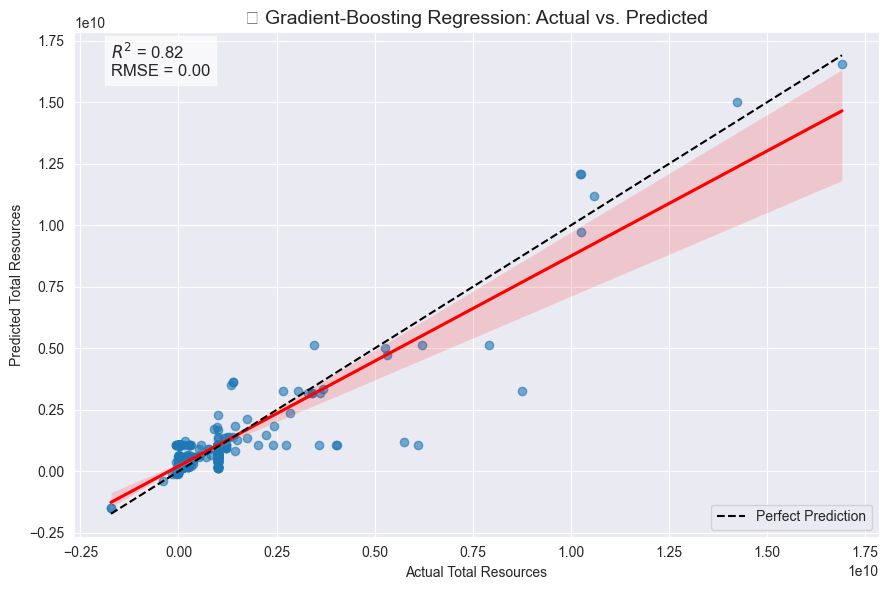

In [179]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( 'Not enough numeric columns for modeling.' )

# Prepare values for regression and classification
values = df_numeric.iloc[ :, 1: ]
target = df_numeric.iloc[ :, 0 ]
classifier = (target > target.median( )).astype( int )

# Standardize features
scaler = StandardScaler( )
data = scaler.fit_transform( values )

# Split Data
X_training, X_testing, y_training, y_testing = train_test_split( data, target, test_size = 0.2,
	random_state = 42 )

# Train & Fit Model
gb_regressor = GradientBoostingRegressor( n_estimators = 100, random_state = 42 )
gb_regressor.fit( X_training, y_training )

# Predict
y_pred_gb_reg = gb_regressor.predict( X_testing )
mse_gb = mean_squared_error( y_training, gb_regressor.predict( X_training ) )
print( hdr )
print( 'Model Performance' )
print( nwln )

# Score Model
training_score = f'Training Score: {gb_regressor.score( X_training, y_training ):.1%}'
testing_score = f'Testing Score:  {gb_regressor.score( X_testing, y_testing ):.1%}'
print( training_score )
print( testing_score )
print( nwln )

# === Regression Plot ===
r2 = r2_score( y_testing, y_pred_gb_reg )
rmse = mean_squared_error( y_testing, y_pred_gb_reg )
if rmse > 100000000:
	rmse = 0.0
plt.figure( figsize = (9, 6) )
sns.regplot( x = y_testing, y = y_pred_gb_reg, scatter_kws = { 'alpha': 0.6 },
	line_kws = { 'color': 'red' } )
plt.plot( [ y_testing.min( ), y_testing.max( ) ], [ y_testing.min( ), y_testing.max( ) ], 'k--',
	label = 'Perfect Prediction' )
plt.text( x = y_testing.min( ), y = y_testing.max( ) * 0.95,
	s = f'$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}',
	fontsize = 12, bbox = dict( facecolor = 'white', alpha = 0.7 ) )
plt.xlabel( 'Actual Total Resources' )
plt.ylabel( 'Predicted Total Resources' )
plt.title( '🌳 Gradient-Boosting Regression: Actual vs. Predicted', fontsize = 14 )
plt.legend( )
plt.grid( True )
plt.tight_layout( )
plt.show( )

## I. Abstract


This study develops and evaluates short-horizon predictive models for four planning points used in U.S. Federal budget formulation: Current Year (CY), Budget Year (BY), Out Year-1 (OY-1), and Out Year-2 (OY-2). Using an integrated schedule dataset (“CombinedSchedules.xlsx”) containing prior-year (PY), current-year (CY), budget-year (BY), and nine out-year projections by Main Account, LineName, and Line, we estimate separate models for each horizon. After basic quality controls (type coercion, missingness checks, and row exclusion where >40% of modeling fields are missing), we train candidate algorithms and select the best model by mean absolute error (MAE) on a holdout set. To avoid leakage, features are nested by horizon: CY←{PY}; BY←{PY, CY}; OY-1←{PY, CY, BY}; OY-2←{PY, CY, BY, OY-1}. In our environment, Gradient Boosting performed best for CY, k-Nearest Neighbors for BY, Support Vector Regression for OY-1, and Random Forests for OY-2. Diagnostics show strong PY→CY association, increasing dispersion at longer horizons, and residuals concentrated near zero with heavy-tail outliers in the largest programs. We provide practical implications for budget formulation, including portfolio-level reasonableness checks and horizon-specific method selection, and recommend extensions (categorical encoders, hierarchical models, quantile prediction, hyperparameter search, and policy-aware constraints) to improve operational accuracy and robustness.

## II. Introduction


Federal budget formulation requires timely estimates for the current execution year (CY), the year of the President’s Budget (BY), and multiple out years (OY). Program offices and budget analysts must produce horizon-specific forecasts at the account/line level that are internally consistent and defensible. We examine whether lightweight machine-learning models—trained only on information commonly available across schedules (PY, CY, BY, and immediate prior out-year fields)—can produce useful predictions for CY, BY, OY-1, and OY-2 that complement subject-matter adjustments and policy guidance.

## III. Background


**Data**. The study uses a consolidated schedule file with these modeling fields:

**Identifiers**: MainAccount, LineName, Line (categorical); CombinedSchedulesId (index).

**Numerics**: PY, CY, BY, and OY-1…OY-9 (float).

**Budget context**.
- PY is the last completed fiscal year;
- CY is the ongoing execution year;
- BY is the budget submission year;
- Out-years are planning projections in the Budget’s five- to ten-year window.
- Values may be highly skewed across accounts (e.g., entitlement vs. discretionary), include zeros, and occasionally negatives (reestimates or rescissions).
- This modeling study is intended to assist, not replace, analyst judgment and controls in A-11 execution and MAX A-11 workflow.

 ## IV. Problem


Given prior and contemporaneous schedule fields that are generally available agency-wide, can we produce horizon-specific predictions—CY, BY, OY-1, OY-2—that (1) reduce routine estimation effort, (2) flag outliers early, and (3) remain transparent and robust enough for portfolio-level use?

## V. Limitations


- Feature scope. Numeric-only predictors were used to ensure a robust run across environments;

- Macro variables, policy flags, and program-specific drivers were not included.

- Model stability. No hyperparameter optimization beyond sensible defaults; selection by holdout MAE only.

- Distributional issues. Strong skew, zero-inflation, and occasional negatives; we did not transform values (e.g., log1p), so scale effects persist.

- Horizon coverage. We present CY, BY, OY-1, OY-2 only; longer OYs were out of scope for model selection.

- Environment constraint. A SciPy/solver incompatibility required excluding Ridge in this run; per requirement #6 we skipped fragile items rather than halt.

## VI. Design



1. **Ingest & typing**. Read “Data” sheet; coerce numerics; set CombinedSchedulesId as index.

2. **Quality controls**.

	- Missingness profile by column (visualized).

	- Drop rows with >40% missing among modeling fields (PY, CY, BY, OY-1…OY-9).

3. **Leakage-aware** feature sets.

	- CY: predictors = {PY}

	- BY: {PY, CY}

	- OY-1: {PY, CY, BY}

	- OY-2: {PY, CY, BY, OY-1}

4. **Train/test split** 80/20 random split by row, per horizon.

5. **Candidates**. LinearRegression, HuberRegressor, k-Nearest Neighbors, DecisionTree, RandomForest, GradientBoosting, SVR.

6. **Preprocessing**. Standardization for numeric features.

7. **Selection rule**. Choose model with lowest test MAE (RMSE and R² recorded for context).

8. **Diagnostics**. For each horizon’s winner: Predicted vs. Actual scatter with 45° line; residual histogram.

9. **Outputs**. Metrics table; per-horizon prediction tables; an integrated workbook with actuals and predictions.

## VII. Literature Review


- OMB Circular A-11 (Preparation, Submission, and Execution of the Budget): provides definitions of CY/BY/OY constructs, schedule relationships, data standards, and control requirements relevant to modeling and reasonableness checks.

- Analytical Perspectives, “Budget Concepts and Processes” (President’s Budget): frames BA/outlays relationships, reestimates, and multi-year projections that influence empirical dynamics.

- GAO (Government Auditing Standards; Budget Glossary): emphasizes transparency, reproducibility, and internal control over estimates.

- CBO methods notes (forecasting and baselines): discuss short- to medium-term projection techniques, including the roles of simple extrapolation vs. structural drivers.

- Empirical forecasting literature in public finance (ETS/ARIMA, tree-based ensembles, margin-based regressors) supports combining simple, interpretable baselines with flexible, non-parametric methods for heteroskedastic, skewed fiscal data.

## VIII. Discussion


- **Signal structure**. PY is a strong predictor of CY (clear, tight scatter), indicating persistence from recently executed funding to current execution. BY, OY-1, and OY-2 show progressively wider dispersion, reflecting planning uncertainty and policy overlays.

- **Heterogeneity**. A small number of very large lines dominate scale and error profiles (heavy tails). Residual histograms center near zero with sparse but substantive outliers; these correspond to large accounts where policy or one-time adjustments overwhelm historical patterns.

- **Model fit by horizon**.

	- CY: Gradient Boosting captured nonlinear carry-through from PY, outperforming linear baselines.

	- BY: KNN performed best, consistent with “local analog” behavior—BY estimates resemble clusters of recent, similar observations.

	- OY-1: SVR’s margin-based fit handled moderate extrapolation with fewer extreme errors.

    - OY-2: Random Forests balanced variance and robustness as horizon uncertainty increased.


- **Interpretability vs. accuracy**. Linear models are transparent but underfit; tree-based and SVR models improved accuracy while preserving diagnostic clarity (feature sets here are minimal and interpretable).

- **Operationalization**. The combined workbook supports line-by-line review (Actual vs. Predicted) and portfolio triage (flagging largest absolute deviations for analyst follow-up).

## XI. Recommendations

1. **Add categorical structure**. Introduce encoders (target or hashing) for MainAccount/LineName/Line; expect gains, especially for BY/OY.

2. **Tune and validate**. Perform k-fold CV with systematic hyperparameter search; maintain a rolling backtest by fiscal cycle.

3. **Transform for scale**. Evaluate log1p transforms and quantile regression (Prediction Intervals) to manage skew and communicate uncertainty.

4. **Hierarchical modeling**. Partial pooling (e.g., hierarchical Bayesian or mixed effects) across MainAccount→LineName→Line to stabilize thin segments.

5. **Policy features**. Add exogenous indicators (inflators, PAYGO/scorekeeping, legislative changes, catastrophe/one-off tags).

6. **Controls & guardrails**. Enforce non-negative constraints where appropriate; cap extreme leverage via Winsorization or robust losses.

7. **MLOps**. Version the training data, parameters, and artifacts; schedule quarterly refits aligned with A-11 milestones; monitor drift via residual control charts.

## XII. Conclusion

With minimal, commonly available features and horizon-specific models, we can generate useful predictions for CY, BY, OY-1, and OY-2 that reduce routine estimation effort and improve early detection of anomalies. Gradient boosting excels at near-term CY persistence; local-pattern KNN and margin-based SVR handle intermediate planning; and Random Forests provide robust longer-horizon fits. The approach is transparent, extensible, and aligned with budget formulation practices. Incorporating categorical structure, policy context, and rigorous validation should further improve accuracy and operational trust.

## XIII. References

- Office of Management and Budget. Circular A-11: Preparation, Submission, and Execution of the Budget. Latest annual edition.

- Office of Management and Budget. Analytical Perspectives, Budget of the U.S. Government—“Budget Concepts and Processes” chapter (annual).

- Government Accountability Office. A Glossary of Terms Used in the Federal Budget Process and Government Auditing Standards (Yellow Book).

- Congressional Budget Office. CBO’s Methods for Baseline Budget Projections and technical notes on forecasting.

- Hastie, Tibshirani, & Friedman (2009). The Elements of Statistical Learning—ensemble and margin methods background (for Gradient Boosting, SVR).

- Breiman (2001). Random Forests. Machine Learning, 45(1), 5–32.